## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

This data set contains three files. The first file describes the characteristics of each offer, including its duration and the amount a customer needs to spend to complete it (difficulty). The second file contains customer demographic data including their age, gender, income, and when they created an account on the Starbucks rewards mobile application. The third file describes customer purchases and when they received, viewed, and completed an offer. An offer is only successful when a customer both views an offer and meets or exceeds its difficulty within the offer's duration.



## Problem Statement / Metrics

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has two steps. First, I will combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I will assess the accuracy and F1-score of a naive model that assumes all offers were successful. This provides me with a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight into its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics".

In [1]:
import re
import math
import json
import progressbar
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



### Import Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Access Portfolio Data

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [6]:
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [7]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [8]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### Clean Portfolio Data:

- portfolio: rename id col name to offer_id.
- portfolio: one-hot encode channels
- portfolio: one-hot encode offer_type column

In [9]:
# portfolio: rename id col name to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [10]:
# portfolio: one-hot encode channels

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)

In [11]:
# portfolio: one-hot encode offer_type column

for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [12]:
portfolio

,reward,difficulty,duration,offer_id,web,email,social,mobile,bogo,informational,discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [13]:
portfolio.duplicated().sum()

0

### 2. Access Profile Data

In [14]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [18]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

### Clean Profile Data
- profile: rename id col name to customer_id.
- profile: change age value 118 to nan.
- profile: create readable date format in became_member_on column.
- profile: drop rows with no gender, income, age data
- profile: convert gender values to numeric 0s and 1s
- profile: add start year and start month columns (for further analysis)

In [19]:
# access the duplicate values
profile.duplicated().sum()

0

In [20]:
# profile: rename id col name customer_id.
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [21]:
profile.where(profile.age==118).count()

gender                 0
age                 2175
customer_id         2175
became_member_on    2175
income                 0
dtype: int64

In [22]:
# profile: change age value 118 to nan.
profile.age.replace(118, np.nan, inplace=True)

In [23]:
# profile: create readable date format for became_member_on column.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]')

In [24]:
len(profile[profile['gender'].isnull()].index)

2175

In [25]:
# profile: drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [26]:
# Convert gender values to numeric 0s and 1s
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [27]:
# profile: add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

In [28]:
profile

,gender,age,customer_id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11
...,...,...,...,...,...,...,...
16995,0,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6
16996,1,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7
16997,1,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1
16998,0,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3


### 3. Access Transcript Data

In [29]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [30]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [31]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Clean Transcript Data
- transcript: rename person col name to customer_id.
- transcript: create separate columns for amount and offer_id from value col.
- transcript: drop transaction rows whose customer_id is not in profile:customer_id
- transcript: convert time in hours to time in days
- transcript: segregate offer and transaction data 
- transcript: finally drop duplicates if any

In [32]:
# transcript: rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [33]:
# transcript: create separate columns for amount and offer_id from value col.

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [34]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [35]:
transcript['time'] /= 24.0

In [36]:
# access the duplicate values
transcript.duplicated().sum()

374

In [37]:
# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

In [38]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  272388 non-null  object 
 1   event        272388 non-null  object 
 2   time         272388 non-null  float64
 3   offer_id     148431 non-null  object 
 4   amount       123957 non-null  float64
dtypes: float64(2), object(3)
memory usage: 10.4+ MB


In [39]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [40]:
# transcript:  segregate offer and transaction data 

# extract transactions from transcript data
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11032,54890f68699049c2a04d415abc25e717,0.00,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
272382,24f56b5e1849462093931b164eb803b5,29.75,22.64
272384,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
272385,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
272386,a00058cf10334a308c68e7631c529907,29.75,3.61


In [41]:
# transcript:  seggregate offer and transaction data 

# extract offer-related from transcript data
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [42]:
transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [43]:
offers_df.viewed.sum(), offers_df.completed.sum(), offers_df.received.sum()

(49860, 32070, 66501)

In [44]:
offers_df

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
...,...,...,...,...,...,...
272343,84fb57a7fe8045a8bf6236738ee73a0f,29.75,5a8bc65990b245e5a138643cd4eb9837,0,0,1
272350,abc4359eb34e4e2ca2349da2ddf771b6,29.75,3f207df678b143eea3cee63160fa8bed,0,0,1
272363,8dda575c2a1d44b9ac8e8b07b93d1f8e,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
272365,8431c16f8e1d440880db371a68f82dd0,29.75,fafdcd668e3743c1bb461111dcafc2a4,0,1,0


## Exploratory Data Analysis

### 1. Profile data

In [45]:
profile

,gender,age,customer_id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11
...,...,...,...,...,...,...,...
16995,0,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6
16996,1,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7
16997,1,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1
16998,0,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3


#### Check for any missing values in each column

In [46]:
profile.isnull().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
start_year          0
start_month         0
dtype: int64

#### Compute gender distribution in customer's data

In [47]:
profile.gender.value_counts()

1    8484
0    6341
Name: gender, dtype: int64

#### Stats of customer age and income attributes when income is specified

In [48]:
profile[profile['income'].notnull()].describe()

,gender,age,income,start_year,start_month
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.572277,54.393524,65404.991568,2016.620169,6.695582
std,0.494765,17.383705,21598.299410,1.198245,3.488853
min,0.000000,18.000000,30000.000000,2013.000000,1.000000
25%,0.000000,42.000000,49000.000000,2016.000000,4.000000
50%,1.000000,55.000000,64000.000000,2017.000000,7.000000
75%,1.000000,66.000000,80000.000000,2017.000000,10.000000
max,1.000000,101.000000,120000.000000,2018.000000,12.000000


#### Compute what percent of customers vs which year enrolled as a member

In [49]:
year_count = profile['start_year'].value_counts()

year_count *= 100 / year_count.sum()
year_count

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: start_year, dtype: float64

#### Compute what percent of customers vs which month enrolled as a member

In [50]:
month_count = profile['became_member_on'].apply(lambda date: date.month).value_counts()

month_count *= 100 / year_count.sum()
month_count.sort_index()

1     1327.0
2     1042.0
3     1145.0
4     1145.0
5     1152.0
6     1105.0
7     1189.0
8     1395.0
9     1299.0
10    1386.0
11    1268.0
12    1372.0
Name: became_member_on, dtype: float64

#### Profile General Distribution — Age, Income, Members

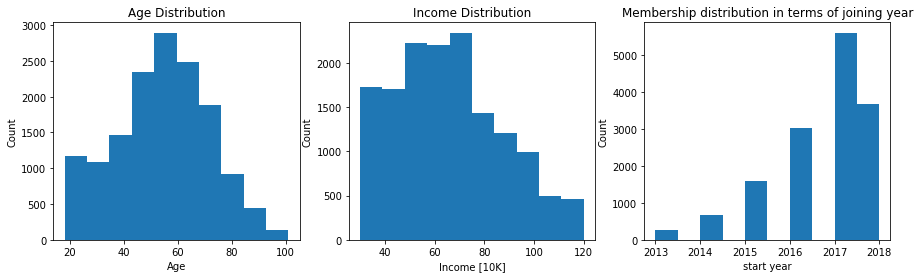

In [51]:
# to be able to draw three subplots in a row
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)

# plot a age distribution in data
plt.sca(ax[0])
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

# plot a income distribution in data
plt.sca(ax[1])
plt.hist(profile['income'] * 1E-3 )
plt.xlabel('Income [10K]')
plt.ylabel('Count')
plt.title('Income Distribution');

# plot a start_year distribution
plt.sca(ax[2])
plt.hist(profile['start_year'])
plt.xlabel('start year')
plt.ylabel('Count')
plt.title('Membership distribution in terms of joining year');

Age distribution plot depicts that the median age of a customer is 60 and most of our customers belong to age range between 40 to 70. Income distribution plot shows that the number of customers whose average salary is less than 70K is high than the other side considering 70K to be median of the income distribution. Membership distribution has interesting results - 2017 has the highest registered customers than any starting from 2013. The plot also shows that there is an increasing trend in the number of registrations except for 2017

#### Income distribution as a function a gender

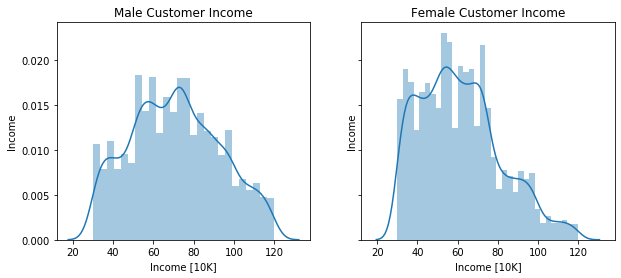

In [52]:
# extract male and female customers
male_customers = profile[profile['gender'] == 0]
female_customers = profile[profile['gender'] == 1]

# to be able to draw two subplots in a row
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Customer Income');

- plots conclude that minimum and maximum income for both male and female are approximately same but the count of male customers in low-income level is slightly higher than that of female customers

#### Age distribution as a function of gender

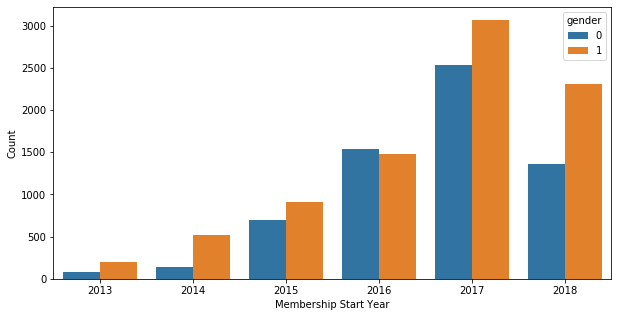

In [53]:
# groupby start_year and gender to plot a graph
membership_date = profile.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

The results suggest that most customers joined the Starbucks rewards program in 2017 followed by 2018. Plots also depict that there are more male customers joining the program every year.

### 2. Transaction data 

#### Compute the event type distribution

In [54]:
event_counts = transcript['event'].value_counts()
event_counts

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [55]:
total_transactions = event_counts.sum()

transactions_perc = 100 * event_counts[0] / total_transactions
offers_perc = 100 * event_counts[1:].sum() / total_transactions

(transactions_perc, offers_perc)

(45.507511344112075, 54.492488655887925)

### Combine offer, customer and transactions data

In [56]:
# https://progressbar-2.readthedocs.io/en/latest/#introduction

def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [57]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:09:23] |##################################| (Time:  0:09:23) 


In [58]:
data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

In [59]:
columns_list = ['time', 'offer_id', 'customer_id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'discount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_on',
                'gender', 'income', 'age', 'start_year', 'start_month']
data[columns_list]

,time,offer_id,customer_id,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,...,email,mobile,social,web,became_member_on,gender,income,age,start_year,start_month
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2017-05-09,0,100000.0,75.0,2017,5
1,7.0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,49.39,0,0,3,0,0.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75.0,2017,5
2,17.0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,10,7,10,1.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75.0,2017,5
3,21.0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,5,5,5,1.0,0.0,...,1.0,1.0,1.0,1.0,2017-05-09,0,100000.0,75.0,2017,5
4,0.0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.00,0,10,7,2,0.0,1.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68.0,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,24.0,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,34.04,0,10,7,2,0.0,1.0,...,1.0,1.0,0.0,1.0,2017-08-20,1,44000.0,59.0,2017,8
66497,24.0,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,19.92,0,0,3,0,0.0,0.0,...,1.0,1.0,1.0,0.0,2017-08-02,1,64000.0,44.0,2017,8
66498,24.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,28.42,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-23,1,73000.0,61.0,2018,4
66499,24.0,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,75.84,1,7,7,3,0.0,1.0,...,1.0,1.0,1.0,1.0,2017-12-23,0,86000.0,52.0,2017,12


In [60]:
data.to_csv('master_offer_analysis.csv', index=False)

In [61]:
data = pd.read_csv('master_offer_analysis.csv')

In [62]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in data.columns if elem not in column_ordering])

data = data[column_ordering]
data = data.drop(columns=['time', 'customer_id', 'email', 'informational', 'became_member_on'])
data.head()

,offer_id,total_amount,offer_successful,reward,difficulty,duration,web,social,mobile,bogo,discount,gender,age,income,start_year,start_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,5,7,1.0,0.0,1.0,1.0,0.0,0,75.0,100000.0,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,0,3,0.0,1.0,1.0,0.0,0.0,0,75.0,100000.0,2017,5
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,10,10,7,0.0,1.0,1.0,1.0,0.0,0,75.0,100000.0,2017,5
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,5,5,5,1.0,1.0,1.0,1.0,0.0,0,75.0,100000.0,2017,5
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,2,10,7,1.0,0.0,1.0,0.0,1.0,1,68.0,70000.0,2018,4


In [63]:
def calculate_percentage_success():
    successful_count = data[['offer_id', 'offer_successful']].groupby(
        'offer_id').sum().reset_index()

    offer_count = data['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    successful_count = successful_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    percent_success = pd.merge(offer_count, successful_count, on="offer_id")

    percent_success['percent_success'] = (
        100 * percent_success['offer_successful'] / percent_success['count'])

    percent_success = pd.merge(percent_success, portfolio, on="offer_id")

    percent_success = percent_success.drop(columns=['offer_successful'])

    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [64]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success,reward,difficulty,duration,web,email,social,mobile,bogo,informational,discount
0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,2,10,10,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,3,7,7,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,10,10,7,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,10,10,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,5,5,7,1.0,1.0,0.0,1.0,1.0,0.0,0.0
6,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,2,10,7,1.0,1.0,0.0,1.0,0.0,0.0,1.0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,5,20,10,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8,3f207df678b143eea3cee63160fa8bed,6657,7.721196,0,0,4,1.0,1.0,0.0,1.0,0.0,1.0,0.0
9,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,0,0,3,0.0,1.0,1.0,1.0,0.0,1.0,0.0


### Generate a plot that illustrates:

- How many customers were provided with a specific offer?
- Offer success rate (percentsuccess)

Text(0, 0.5, 'Success percentage')

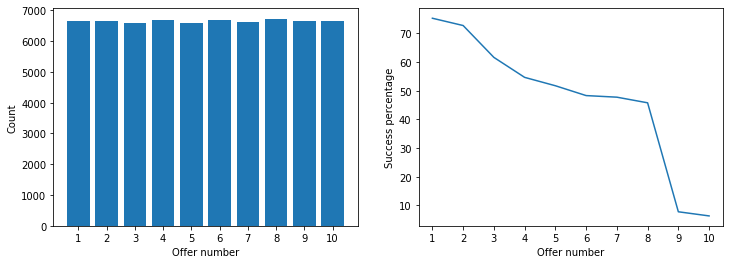

In [65]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer number')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1, percent_success['percent_success'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer number')
ax[1].set_ylabel('Success percentage')

## Build models

### Create train and test data sets 

In [66]:
# factors/features that influence the label variable
features = data.drop(columns=['offer_successful'])

# label variable to predict
label = data.filter(['offer_successful'])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

# test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

### Evaluate Naive Predictor Performance

In [67]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


### Construct Logistic Regression Model

In [68]:
scorer = make_scorer(fbeta_score, beta=0.5)

# instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# fit train data to the model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   22.3s finished
/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=6, n_jobs=3,
                   param_distributions={'C': [1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False,
                   scoring=make_scor

In [69]:
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [70]:
# evaluate logistic regression model's performance
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.698
LogisticRegression model f1-score: 0.693


(0.6977873254564984, 0.6932536740656753)

#### Results
- Results suggest that a logistic regression model's accuracy and f1-score is better than the naive predictor
- Accuracy
    - Naive predictor: 0.471
    - Logistic regression: 0.697
- F1-score
    - Naive predictor: 0.640
    - Logistic regression: 0.693

### Evaluate Test Data Performance

In [71]:
evaluate_model_performance(lr_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.702
RandomizedSearchCV model f1-score: 0.698


(0.7016690892687083, 0.6975302368126843)

### Construct Random Forest Classifier Model

In [72]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   29.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  3.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [73]:
# evaluate random forest classifier model's performance
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.761
RandomForestClassifier model f1-score: 0.751


(0.7610526315789473, 0.751357997093998)

#### Results
- Results suggest that a random forest model's accuracy and f1-score is better than the naive predictor
- Accuracy
    - Naive predictor: 0.471
    - Random forest: 0.762
- F1-score
    - Naive predictor: 0.640
    - Random forest: 0.753

### Evaluate Test Data Performance

In [74]:
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.738
RandomForestClassifier model f1-score: 0.729


(0.7384592251014986, 0.7293287685444549)

NOTE: Few things to consider while constructing these models - all features were converted to numericals to fit and train above models. Bias and variance are two characteristics of a machine learning model. Bias refers to inherent model assumptions regarding the decision boundary between different classes. On the other hand, variance refers a model's sensitivity to changes in its inputs. These can influence our results sometimes so models have to be tested throughly against bias and variance. Also, while splitting train and test datasets and tuning parameters to fit a model, we will have to make sure that data doesn't overfit the model. 

## Conclusion

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has mainly two steps. First, I combined offer portfolio, customer profile, and transaction data. Second, I assessed the accuracy and F1-score of a naive model that assumes all offers were successful. Third, I compared the performance of logistic regression and random forest models. This analysis suggests that a random forest model has the best training data accuracy and F1-score. Analysis suggests that random forest model has a training data accuracy of 0.762 and an F1-score of 0.753. The test data set accuracy of 0.740 and F1-score of 0.730 suggests that the random forest model I constructed did not overfit the training data.

However, the performance of a random forest model can be still improved by analysing features which impacts an offer’s success rate as a function of offer difficulty, duration, and reward. These additional features should provide a random forest classifier with the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.

Also, initially it seemed like we had a lot of data to work, but once NaN values and duplicate columns were dropped and the data were combined into one single dataset, it felt as though the models might have benefited from more data. With more data, the classification models may have been able to produce better accuracy and F1-score results.

Additionally, better predictions may have been deducted if there were more customer metrics. For this analysis, I feel we had limited information about customer available to us — just age, gender, and income. To find optimal customer demographics, it would be nice to have a few more features of a customer. These additional features may aid in providing better classification model results.